In [2]:
!pip install quantities --quiet
!pip install neo --quiet
!pip install elephant --quiet

In [3]:
import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [5]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# Data description

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

# Spike Labeling

* We are doing spike labeling based on: [(Loren M. Frank, Emery N. Brown, and Matthew A. Wilson, 2001)](https://journals.physiology.org/doi/full/10.1152/jn.2001.86.4.2029) in which putativa excitatory neurons (PE) had >0.4 trough to peak time $ms$ and <5 $Hz$ mean firing rate, in the other hand putative inhibitory neurons had <0.4 trough to peak time and >5 $Hz$ mean firing rate.



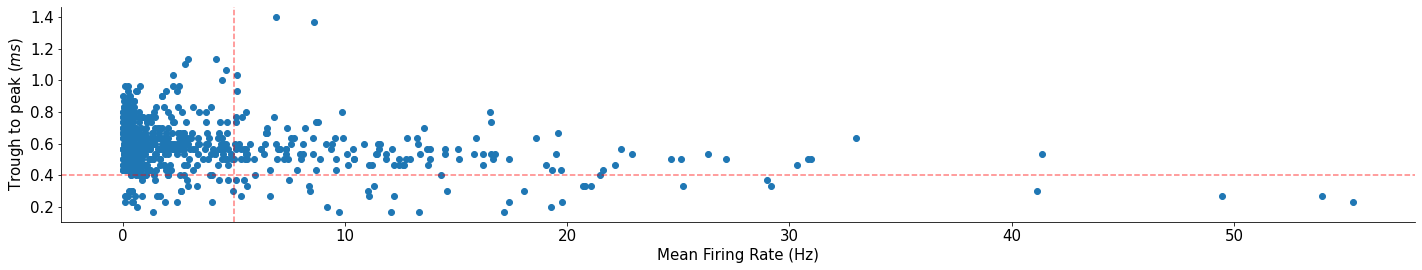

In [8]:
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms
plt.scatter(mean_firing,t_t_peak)
plt.axhline(y=0.4,ls = '--', alpha = 0.5, c = 'r')
plt.axvline(x=5,ls = '--', alpha = 0.5, c = 'r')
plt.ylabel('Trough to peak ($ms$)')
plt.xlabel('Mean Firing Rate (Hz)');


Next, we create a dataframe, and construct a column replacing brain regions per its area:

In [9]:
labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

Labeling according to conditions:

* Default condition is *other*

In [10]:
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

In [11]:
labeling_df.head()

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory


In [9]:
import plotly.express as px

px.scatter(x="Mean Firing Rate", y ="Trough to peak", color = "Cell Type", data_frame = labeling_df)

In [10]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
# 
Selection = (labeling_df['Area']=='Thalamus') & (labeling_df['Cell Type']=='Excitatory')
spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
spikes.shape

(340, 250)

In [11]:
mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
time = binsize * np.arange(dat['spks'].shape[-1])

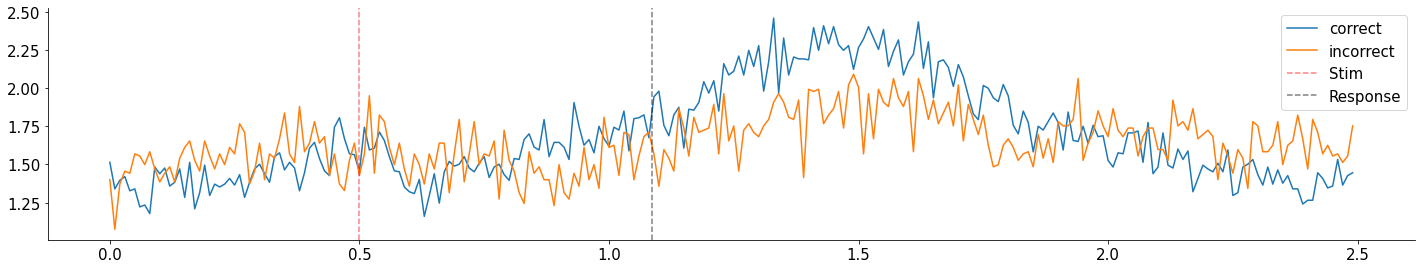

In [12]:
plt.plot(time, mean_fr_e,label='correct')
plt.plot(time, mean_fr_i,label='incorrect')
plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')

plt.legend()

# --- DEAD END ---
# Raster plot

In [6]:
spikes= dat2['ss']

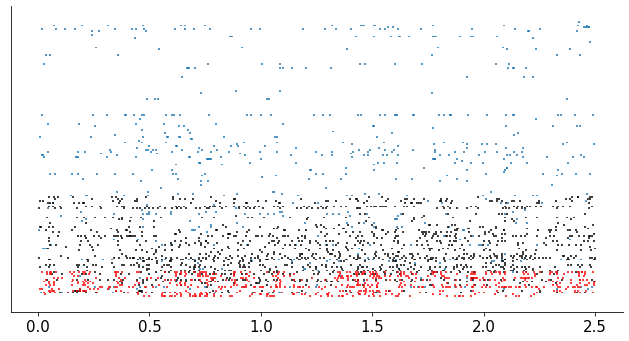

In [12]:
plt.figure(figsize=(9,5))
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Excitatory')][:,3]);
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Other')][:,3],color='k');
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Inhibitory')][:,3],colors = 'r');
plt.yticks([]);

In [20]:
bin_spk_hip = dat['spks'][(labeling_df['Area']=='Hippocampus')]
bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)

In [60]:
340*220

74800

In [54]:
ravel_matrix = np.ravel(bin_spk_hip).reshape(250,-1)
ravel_matrix.shape

(250, 74800)

In [55]:
from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(n_components=2, random_state=0)
FA_fitted = transformer.fit(ravel_matrix)


In [61]:
FA_fitted.components_[0].reshape(340,220)

array([[ 0.04612728,  0.00085663, -0.00416221, ...,  0.02820855,
         0.01892988,  0.0211588 ],
       [ 0.02513643,  0.0286854 ,  0.01200416, ...,  0.04579577,
         0.03627228,  0.01253277],
       [ 0.04414285,  0.01157292,  0.03640945, ...,  0.03178388,
         0.03494496,  0.03728679],
       ...,
       [ 0.00356481, -0.01308261, -0.01484072, ..., -0.0195667 ,
        -0.00978391, -0.00870575],
       [-0.02274431, -0.01323471,  0.00211707, ..., -0.0137367 ,
        -0.00425387,  0.00141073],
       [-0.01700371, -0.02494981, -0.02192419, ..., -0.0433111 ,
        -0.01371929, -0.03626851]])

In [62]:
x_transfomed = transformer.fit_transform(ravel_matrix)

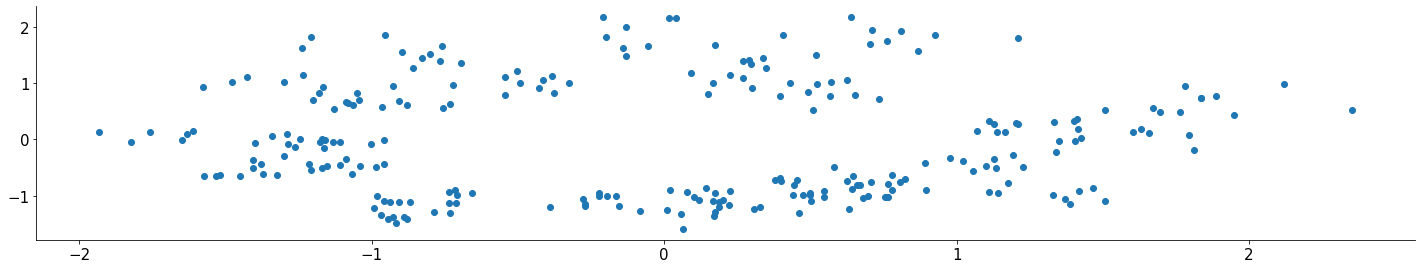

In [69]:
plt.scatter(x_transfomed[:,0],x_transfomed[:,1])

In [17]:
# from neo.core import SpikeTrain
# from quantities import ms
# bin_spk_hip = spikes[(labeling_df['Area']=='Hippocampus')]
# bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)
# trials = np.arange(bin_spk_hip.shape[0])
# neurons = np.arange(bin_spk_hip.shape[1])
# Recording = []
# Trials = []
# for trial in trials:
#   for neuron in neurons:
#     Recording.append(SpikeTrain(bin_spk_hip[trial,neuron]* (ms),t_stop=250))
#   Trials.append(Recording)
#   from elephant.gpfa import GPFA

# # specify fitting parameters
# bin_size = 10 * ms
# latent_dimensionality = 2

# gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

# trajectories_all = gpfa_2dim.fit_transform(Trials[0])

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.legend()

plt.tight_layout()
plt.show()